In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json

import pandas as pd
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

import keras
from keras.layers import GlobalMaxPooling2D

print("TensorFlow:", tf.__version__)

TensorFlow: 2.9.1


In [13]:
# train_samples = pd.read_csv('utils/path_data.csv',dtype=object, header=None, names = ['imagePath', 'label'])
# train_samples['imagePath'] = 'wikiart/' + train_samples['imagePath'].astype(str)
# train_samples = train_samples[:10000]
# print(train_samples.shape)

## labels to remove
removeLabels = ['1','2','6','10','16','18','25']

train_samples = pd.read_csv('utils/style_train.csv',dtype=object, header=None, names = ['imagePath', 'label'])

train_samples = train_samples.loc[~train_samples["label"].isin(removeLabels)]
train_samples = train_samples[:10000]
train_samples = train_samples.reset_index(drop=True)
print(train_samples.shape)

(10000, 2)


In [14]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input

# Model reconstruction from JSON file
with open('models/autoencoder_512_new.json', 'r') as f:
    encoder = model_from_json(f.read())

# Load weights into the new model
encoder.load_weights("models/autoencoder_512_new.hdf5")
encoder.compile(optimizer="adam", loss="mse")
encoder = tf.keras.models.Model(inputs=encoder.input, outputs=encoder.get_layer('encoder').output)

# Add Layer Embedding
model = keras.Sequential([
    # base_model,
    encoder,
    GlobalMaxPooling2D()
])

# base_model = ResNet50(weights ='imagenet', include_top = False, input_shape = (224,224,3))
# base_model.trainable = False
# model = keras.Sequential([base_model, GlobalMaxPooling2D()])
# base_model.summary()
# print(base_model.layers[-1].output_shape)
model.summary()

def get_embedding(model, img_path):
    # Reshape
    try:
        img = Image.open(img_path).convert('RGB') ## RGB for 3 channels, L for grayscale
        size = 224, 224
        img = img.resize(size, Image.Resampling.LANCZOS)
        img = np.asarray(img)
        img = img.astype('float32')/255.
    # img = img.astype('float32')

    # img = preprocess_input(img)
        x  = np.expand_dims(img, axis=0)
    except:
        print(img_path)
        with open('img_errors.txt', 'a') as f:
            f.writelines((img_path)+'\n')
        return
    return model.predict(x).reshape(-1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 14, 14, 512)       1550976   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
Total params: 1,550,976
Trainable params: 1,550,976
Non-trainable params: 0
_________________________________________________________________


In [7]:
# from matplotlib import pyplot as plt

# embedding = get_embedding(model, train_samples.iloc[0].imagePath)
# print(embedding.shape)

# img_array= Image.open(train_samples.iloc[0].imagePath).convert('RGB') ## RGB for 3 channels, L for grayscale
# size = 224,224
# img_array = img_array.resize(size, Image.ANTIALIAS)
# img_array = np.asarray(img_array)

# plt.imshow(img_array, interpolation='nearest')
# plt.show()


# print(img_array.shape)
# print(embedding)

## Creating the Embedding Space MAP

In [15]:
## Creating the Embedding Space MAP
# Parallel apply
map_embeddings = train_samples['imagePath'].apply(lambda img: get_embedding(model, img))
embedded_df = map_embeddings.apply(pd.Series)
embedded_df = embedded_df.dropna()

print(embedded_df.shape)
embedded_df.head()
embedded_df.to_csv("embedded_data_512_new.csv", index = False, encoding = 'utf-8')


1/1 [==============================] - 0s 14ms/step
(10000, 512)


### Calculate Cosine-Distance

In [16]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matriz
cosine_sim = 1-pairwise_distances(embedded_df, metric='cosine')
print(cosine_sim.shape)
cosine_sim[:4, :4]

(10000, 10000)


array([[0.99999976, 0.9511465 , 0.9127245 , 0.95977   ],
       [0.9511465 , 0.9999995 , 0.9393467 , 0.9602237 ],
       [0.9127245 , 0.9393467 , 1.        , 0.93141353],
       [0.95977   , 0.9602237 , 0.93141353, 0.9999999 ]], dtype=float32)

In [17]:
indices = pd.Series(range(len(train_samples)), index=train_samples.index)
print(indices)

def get_recommender(idx, df, top_n = 5):
    sim_idx = indices[idx]
    print("Sim IDX: ", sim_idx)
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # sim_scores = sim_scores[1:top_n+1]
    sim_scores = sim_scores[0:top_n]
    idx_rec = [i[0] for i in sim_scores]
    idx_sim = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

0          0
1          1
2          2
3          3
4          4
        ... 
9995    9995
9996    9996
9997    9997
9998    9998
9999    9999
Length: 10000, dtype: int64


Sim IDX:  0
Int64Index([0, 1498, 8028, 1113, 7435, 737], dtype='int64')
[0.99999976, 0.97717226, 0.9743206, 0.9739557, 0.97384465, 0.97365236]
Index:  0
Image:  wikiart/Impressionism/edgar-degas_landscape-on-the-orne.jpg


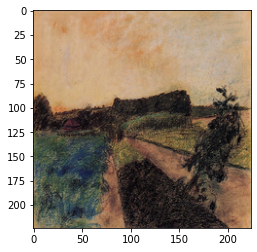

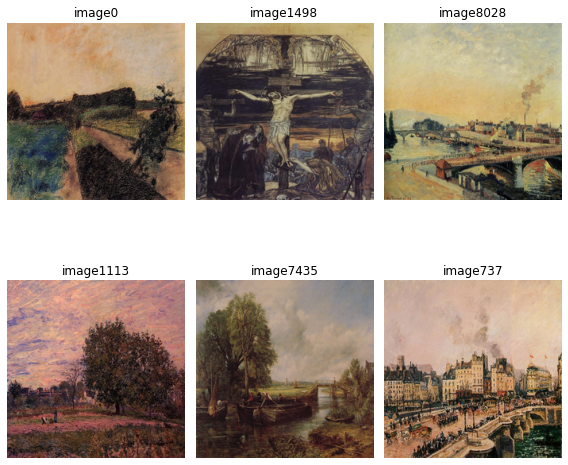

In [19]:
import matplotlib
# Idx Item to Recommender
idx_ref = 0

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, 0, top_n = 6)
print(idx_rec)
print(idx_sim)

def plot_figures(figures, nrows = 1, ncols=1, figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title])
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

def load_image(img_path):
    img = Image.open(img_path).convert('RGB') ## RGB for 3 channels, L for grayscale
    size = 224, 224
    # img.thumbnail(size,Image.ANTIALIAS)
    img = img.resize(size, Image.Resampling.LANCZOS)
    img = np.asarray(img)
    img = img.astype('float32')/255.
    # print(img.shape)
    # print(img)
    return img
    
# Plot
#===================
print("Index: ", idx_ref)
print("Image: ", train_samples.iloc[idx_ref].imagePath)
plt.imshow(load_image(train_samples.iloc[idx_ref].imagePath))
plt.show()

# generation of a dictionary of (title, images)
figures = {'image'+str(i): load_image(row.imagePath) for i, row in train_samples.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)
# for i, row in train_samples.loc[idx_rec].iterrows():
#     print("Index: ", i)
#     print(row.imagePath)
#     plt.imshow(load_image(row.imagePath))
#     plt.show()